<a href="https://colab.research.google.com/github/MariPinas/data_science_2025/blob/main/notebooks/Lab10_ML/exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercício Desafiador: Detecção de Diabetes com Classificadores Supervisionados

## Objetivo
Desenvolver um sistema completo de classificação para prever o diagnóstico de diabetes em mulheres de origem indígena Pima, com base em variáveis clínicas. O exercício envolve desde a preparação dos dados até a avaliação comparativa de diversos modelos.


#### **Base utilizada:** *Pima Indians Diabetes Database*
Dataset disponível aqui no repositório.

### Dicionário de Atributos (Traduzido)
| Atributo | Descrição |
|----------|-----------|
| `preg` | Número de gestações |
| `plas` | Concentração de glicose na hora do teste oral de glicose |
| `pres` | Pressão arterial diastólica (mm Hg) |
| `skin` | Espessura da dobra cutânea do tríceps (mm) |
| `insu` | Nível de insulina sérica (mu U/ml) |
| `mass` | Índice de massa corporal (IMC) |
| `pedi` | Função pedigree do diabetes (histórico familiar) |
| `age` | Idade (anos) |
| `class` | Diagnóstico (0 = negativo, 1 = positivo para diabetes) |

**Responder às perguntas a seguir**
   - Qual modelo teve o melhor **recall**? Por que isso é importante para diagnóstico?
   - Houve modelo com alto **precision**, mas baixo **recall**? O que isso representa?
   - Qual modelo teve o melhor equilíbrio geral (F1-score)?
   - Qual modelo você recomendaria para ser usado em produção hospitalar?

In [217]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [218]:
from google.colab import drive
drive.mount('/content/drive')
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]

df = pd.read_csv("/content/drive/MyDrive/DataScience-2025/diabetes.csv", sep=',', names=column_names, header=0)

cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
df.isnull().sum()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


## 1. Verificando a estrutura dos dados

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


### **Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

In [220]:
print(f'O dataset possui {df.shape[0]} entradas (registros) e {df.shape[1]} atributos (variáveis).')

# Tipos de dados dos atributos
print(f'\nOs tipos dos atributos são do tipo:\n{df.dtypes}')

O dataset possui 768 entradas (registros) e 9 atributos (variáveis).

Os tipos dos atributos são do tipo:
Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


### **Qual a porcentagem de valores ausentes no *dataset*?**

In [221]:
print(f'As variáveis com mais dados faltantes, em porcentagem (%), são:\n')
((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False)

As variáveis com mais dados faltantes, em porcentagem (%), são:



,0
Insulin,48.697917
SkinThickness,29.557292
BloodPressure,4.557292
BMI,1.432292
Glucose,0.651042
Pregnancies,0.000000
DiabetesPedigreeFunction,0.000000
Age,0.000000
Outcome,0.000000


### **Qual o tipo de distribuição das variáveis?**


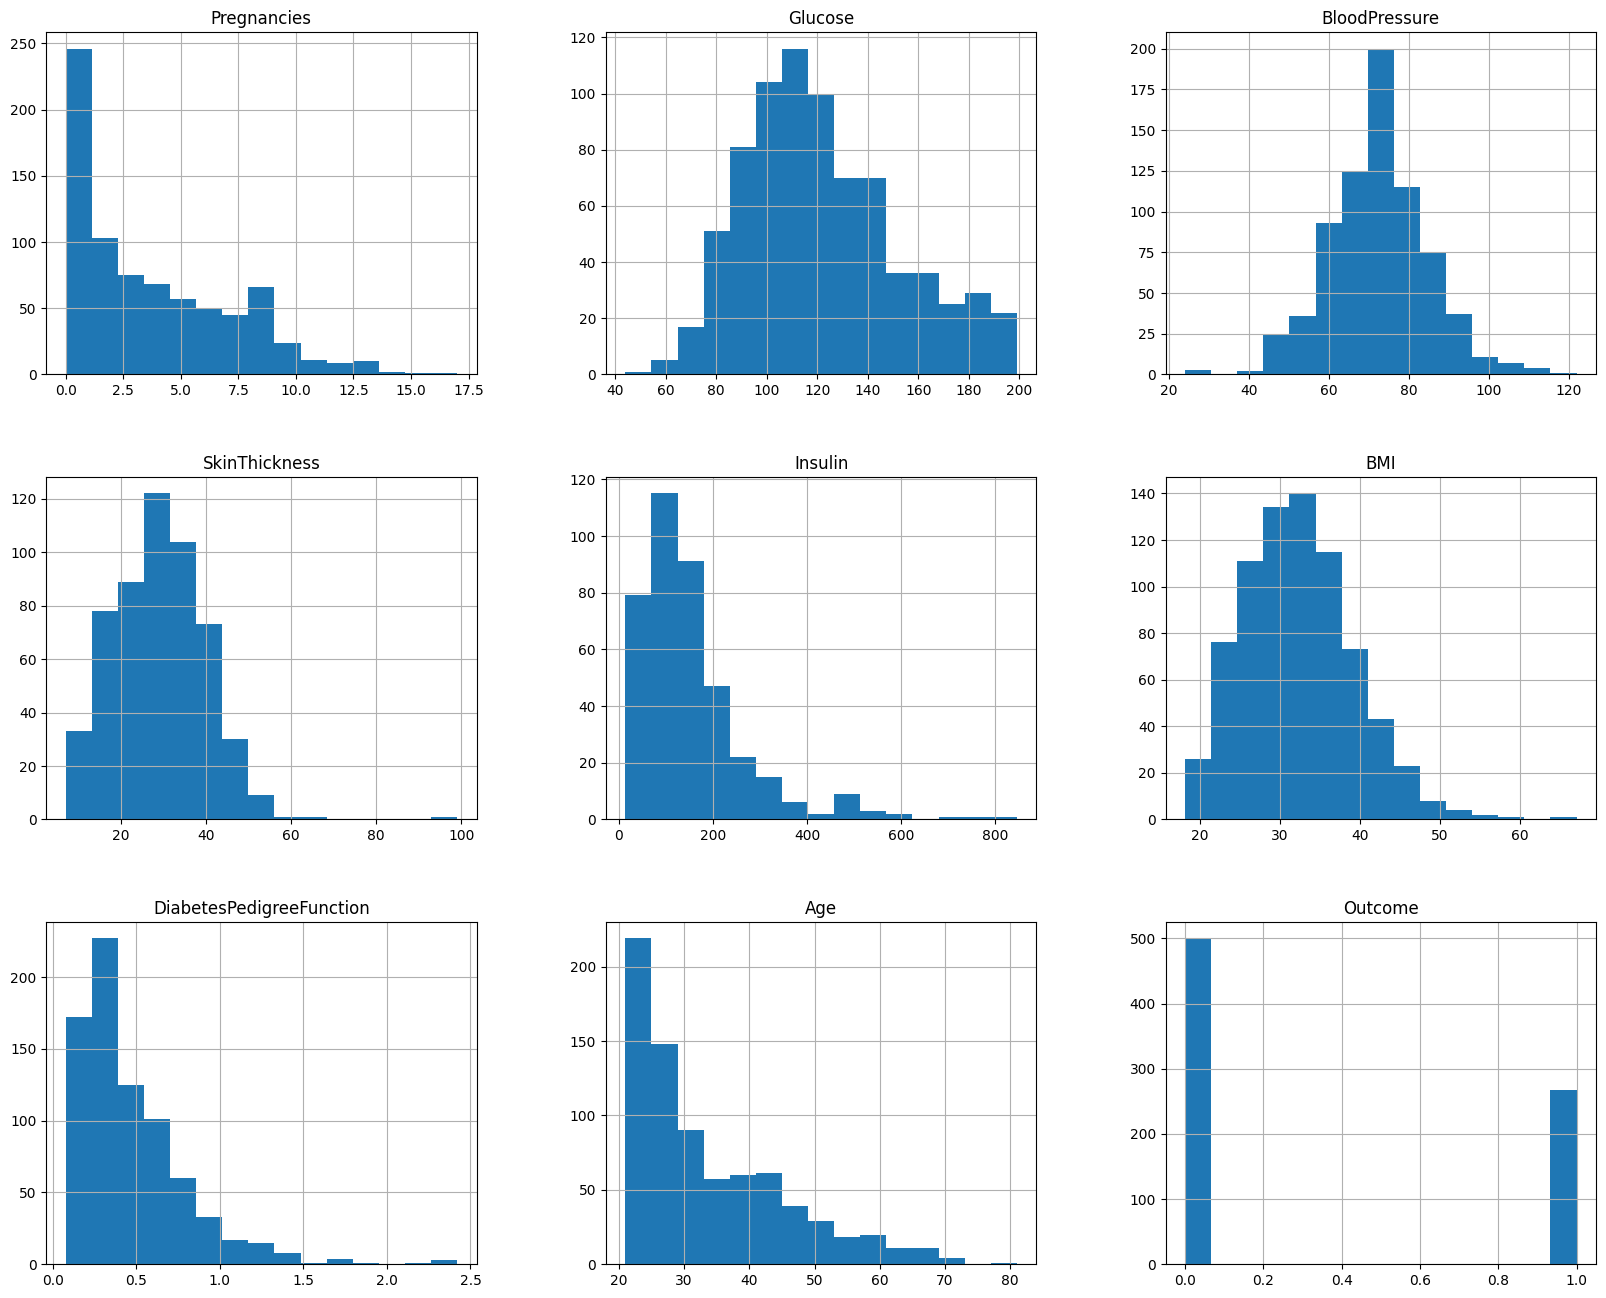

In [222]:
df.hist(bins=15, figsize=(20,16));

## 2. Estatísticas descritivas iniciais

In [223]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3. Verificando valores ausentes ou inválidos
Na base, alguns campos têm o valor **0** que pode indicar ausência de medição (por exemplo, pressão arterial = 0). Vamos verificar esses casos.

In [224]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    print(f"{col} - Total de zeros: { (df[col] == 0).sum() }")

Glucose - Total de zeros: 0
BloodPressure - Total de zeros: 0
SkinThickness - Total de zeros: 0
Insulin - Total de zeros: 0
BMI - Total de zeros: 0


In [225]:
# Substituindo zeros por NaN e contando os valores ausentes
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
df.isnull().sum()
df.dropna(inplace=True)

## 5. Visualizando distribuições e outliers

In [226]:
def detectar_outliers_iqr(coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    return outliers

outliers_insulin = detectar_outliers_iqr('Insulin')

print(outliers_insulin)

#remover outliers
df = df.drop(outliers_insulin.index)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
111            8    155.0           62.0           26.0    495.0  34.0   
153            1    153.0           82.0           42.0    485.0  40.6   
186            8    181.0           68.0           36.0    495.0  30.1   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
231            6    134.0           80.0           37.0    370.0  46.2   
247            0    165.0           90.0           33.0    680.0  52.3   
248            9    124.0           70.0           33.0    402.0  35.4   
258            1    193.0           50.0           16.0    375.0  25.9   
286            5    155.0           84.0           44.0    545.0  38.7   
296            2    146.0           70

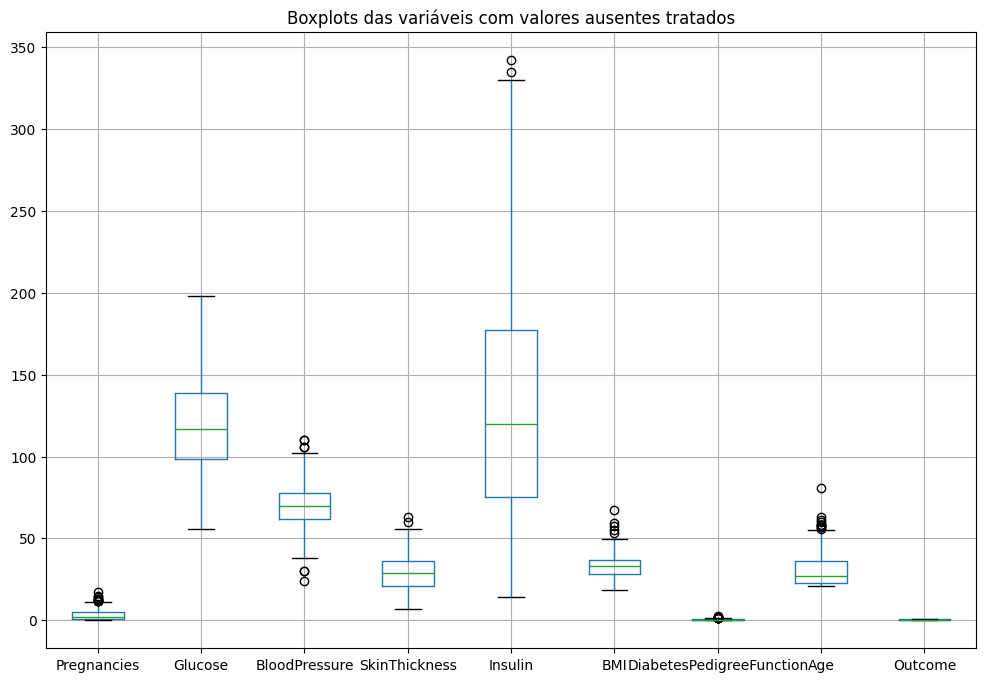

In [227]:
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title("Boxplots das variáveis com valores ausentes tratados")
plt.show()

In [228]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000
mean,3.294278,119.923706,70.653951,28.880109,132.408719,32.916076,0.518038,30.694823,0.313351
std,3.232442,29.483990,12.543155,10.496255,73.377210,7.027101,0.327809,10.023173,0.464489
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.500000,62.000000,21.000000,75.000000,28.000000,0.270500,23.000000,0.000000
50%,2.000000,117.000000,70.000000,29.000000,120.000000,33.100000,0.452000,27.000000,0.000000
75%,5.000000,138.500000,78.000000,36.000000,177.000000,36.900000,0.684500,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,342.000000,67.100000,2.420000,81.000000,1.000000


In [229]:
# Selecionando as features (X) e o target (y)
X = df.drop('Outcome', axis=1) # Todas as colunas, exceto 'Outcome'
y = df['Outcome'] # A coluna 'Outcome' é o target
class_names  = {"Sim": 1, "Não": 0}

In [230]:
# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Separar treino e teste

In [231]:
# Splitando os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

## 06. Algoritmos de classificação

In [232]:
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=200),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf'),
    "K-NN": KNeighborsClassifier(n_neighbors=5)
}

## 07. Avaliação por modelo


 Regressão Logística
Acurácia : 0.68
Precisão : 0.65
Recall   : 0.64
F1-Score : 0.64


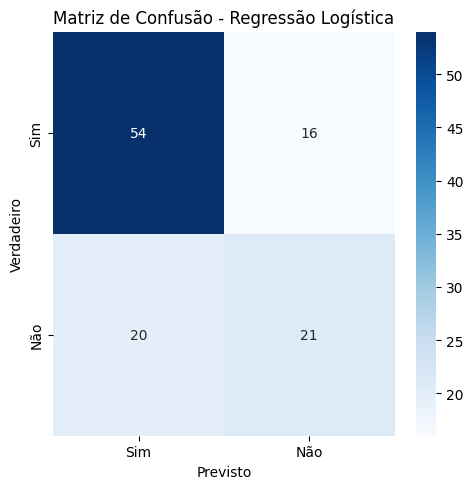


 Árvore de Decisão
Acurácia : 0.68
Precisão : 0.65
Recall   : 0.64
F1-Score : 0.64


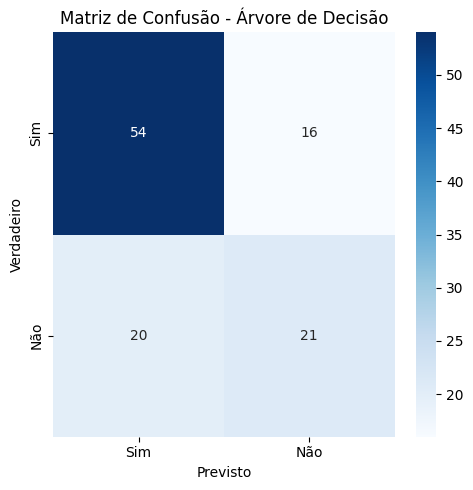


 Random Forest
Acurácia : 0.68
Precisão : 0.66
Recall   : 0.65
F1-Score : 0.66


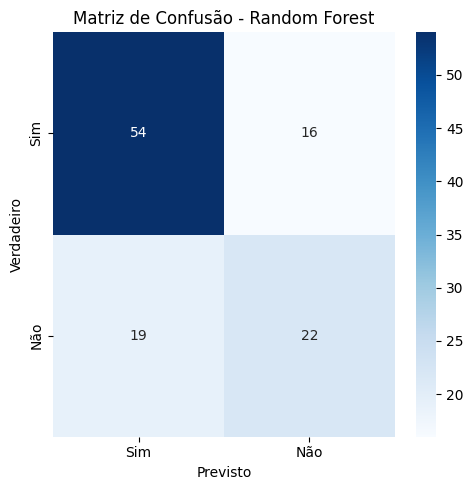


 SVM
Acurácia : 0.71
Precisão : 0.69
Recall   : 0.68
F1-Score : 0.68


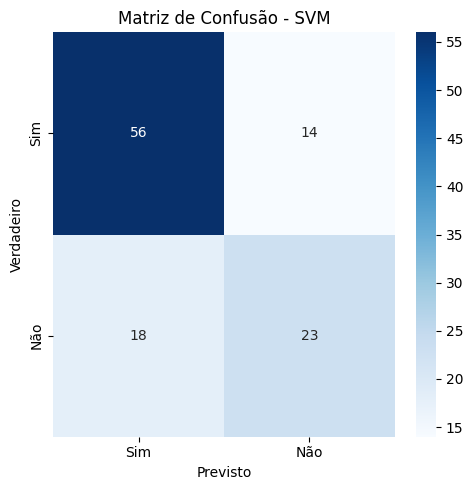


 K-NN
Acurácia : 0.70
Precisão : 0.68
Recall   : 0.66
F1-Score : 0.67


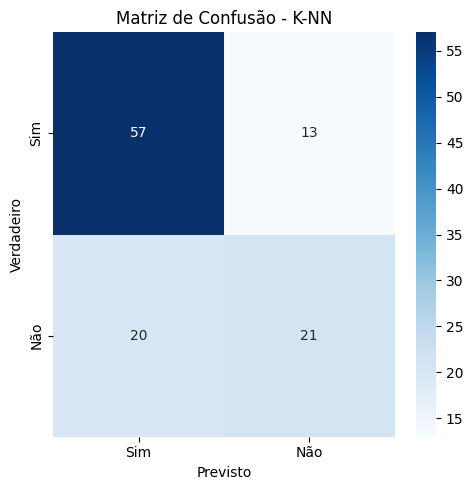

In [233]:
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n {nome}")
    print(f"Acurácia : {acc:.2f}")
    print(f"Precisão : {prec:.2f}")
    print(f"Recall   : {rec:.2f}")
    print(f"F1-Score : {f1:.2f}")

    # Matriz de confusão
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()

* Qual modelo teve o melhor recall? O SVM
* Por que isso é importante para diagnóstico? Para conseguir identificar todas (ou a maior parte possível) das pessoas com diabetes.
* Houve modelo com alto precision, mas baixo recall? O que isso representa? Não. Representa que o modelo consegue prever as classes corretas (Diabético ou não), mas em um consultório não consegue identificar todas corretamente.
* Qual modelo teve o melhor equilíbrio geral (F1-score)? SVM
* Qual modelo você recomendaria para ser usado em produção hospitalar? O SVM